In [1]:
from tqdm import tqdm
import torch
import numpy as np
import torch.nn as nn
from droneDS1.settingsDrone import IMAGE_PATH, NUM_EPOCHS, MASK_PATH, LEARNING_RATE, device
from droneDS1.model_droneDS import UNET_drone as UNET_d
from droneDS1.droneDataset import DroneDataset
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from PIL import Image
import os
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
from typing import Tuple
from torchsummary import summary
import albumentations as A
from droneDS1.model_droneDS import UNET_drone as UNET_d
from droneDS1.droneDataset import DroneDataset
from droneDS1.droneDatasetTest import DroneTestDataset

In [9]:
from droneDS1.model_droneDS import UNET_drone as UNET_d

model = UNET_d()

## Can uncomment the next line if your device has gpu
# mdl.load_state_dict(torch.load('./models/unet_nov18.pth'))

model.load_state_dict(torch.load('./models/unet_model_drone_0.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
def create_df():
        name = []
        for dirname, _, filenames in os.walk(IMAGE_PATH):
            for filename in filenames:
                name.append(filename.split('.')[0])
        return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()

    #split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                    A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                    A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

    #datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

In [3]:
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [4]:
import torch.nn.functional as F

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [5]:
from torchvision import transforms as T

def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [6]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = 0#pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [11]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [12]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [14]:
# mob_miou = miou_score(model, test_set)

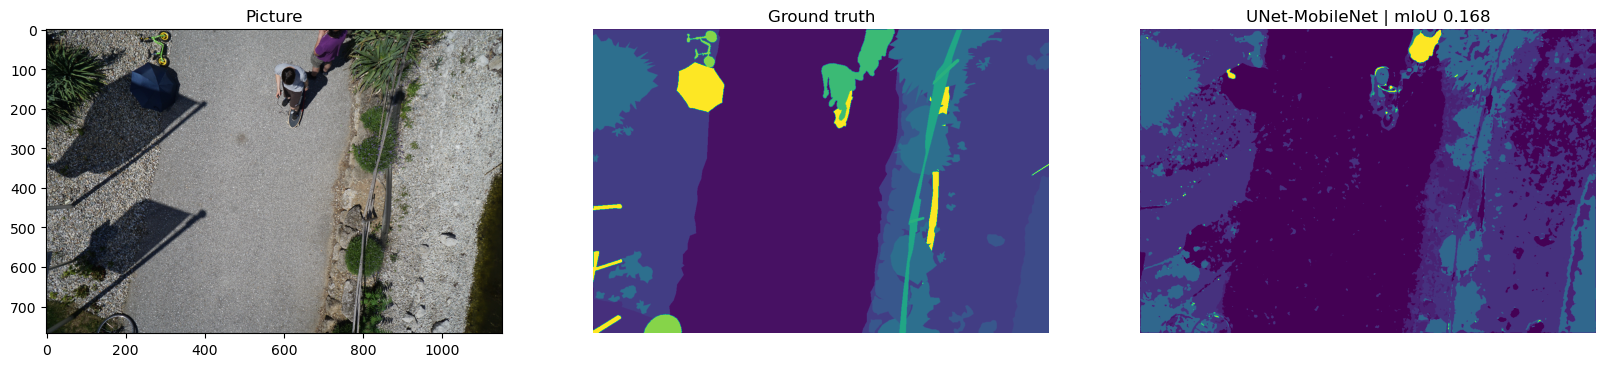

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()